In [56]:
import os
import json
import math
from datetime import date, time, timedelta, datetime
from urllib.request import urlopen

import pandas as pd
import geopandas as gp
import contextily as cx
import googlemaps
from bs4 import BeautifulSoup

pd.options.plotting.backend = 'plotly'

def cache_or_load_gdf(fname, load_f):
  if os.path.exists(fname):
    return gp.GeoDataFrame.from_file(fname)
  else:
    gdf = load_f()
    gdf.to_file(fname, driver='GeoJSON')
    return gdf

def cache_or_load_df(fname, load_f):
  if os.path.exists(fname):
    return pd.read_csv(fname)
  else:
    df = load_f()
    df.to_csv(fname)
    return df

def next_weekday(weekday):
  today = date.today() 
  return today + timedelta(days=7 - today.weekday() + weekday)

GMAPS_API_KEY_PATH='./.gcloud.key'
CRAGS_AREA='Stockholm' # area for which filter the crags
CRAG_TYPE='sport' # 'all', 'sport', 'trad', 'boulder', 'dws'
TRAVEL_FROM='Slussen, Södermalmstorg, 116 46 Stockholm'
TRAVEL_MODE='transit' # or 'driving'
TRAVEL_DEPARTURE_TIME=datetime.combine(next_weekday(5), time(10)) # next saturday 10am
MIN_GRADE='6a'
MAX_GRADE='6c'
WALL_TYPE='any' # 'any', 'overhang', 'vertical', 'slab'

# Data Preparation

[27Crags](https://27crags.com) will serve as a source for user-provided data, sadly it doesn't provide better crag functions by itself.

## Crags

In [3]:
def get_crags_raw():
  crags_soup = BeautifulSoup(urlopen('https://27crags.com/crags'))
  raw_json = crags_soup.find(attrs={'data-component-name': 'Mapbox'}).string
  parsed_json = json.loads(raw_json)
  return parsed_json['crags']

def parse_crags_raw(crags_raw):
  crags_df = pd.DataFrame(crags_raw).r
  # out of ~21k crags only 14k have coordinates
  crags_df.dropna(how='any', inplace=True)
  points = gp.points_from_xy(crags_df['longitude'], crags_df['latitude'])
  crags_df.drop(['latitude', 'longitude'], axis=1, inplace=True)
  return gp.GeoDataFrame(crags_df, geometry=points, crs="EPSG:4326")

def get_crags_gdf():
  return parse_crags_raw(get_crags_raw())

crags = cache_or_load_gdf('./data/crags.geojson', get_crags_gdf)
crags

,id,name,sport_count,trad_n_p_count,boulder_count,likes_count,premium_topo_active,dws_count,geometry
0,1,Olhava,5,90,2,290,True,0,POINT (26.84650 61.18690)
1,2,Peñón de Ifach,7,23,0,25,True,0,POINT (0.07583 38.63460)
2,3,Forte,0,0,7,38,True,0,POINT (25.77627 62.11019)
3,4,28.7,0,0,66,119,False,0,POINT (25.77900 62.36320)
4,5,Keljonkangas,0,0,69,94,True,0,POINT (25.72270 62.19120)
...,...,...,...,...,...,...,...,...,...
14843,25454,MURUS,0,0,0,0,False,0,POINT (-8.59787 41.11858)
14844,25455,Garphytte klint,0,0,2,0,False,0,POINT (14.93974 59.31162)
14845,25456,Leijakivi,0,0,2,0,False,0,POINT (25.30964 61.39174)
14846,25458,Media Thule,2,1,0,0,False,0,POINT (16.29664 68.41908)


## Administrative Borders

Since crags only contain coordinates, but no country or region information exists. This can be added using administrative borders on one of the geographic datasets, eg from [Natural Earth](https://www.naturalearthdata.com/).

In [4]:
def get_admin_borders():
  admin_borders = gp.read_file('https://github.com/nvkelso/natural-earth-vector/raw/master/geojson/ne_10m_admin_1_states_provinces.geojson')
  admin_borders.drop(admin_borders.columns.difference(['name', 'geometry', 'iso_a2']), axis=1, inplace=True)
  return admin_borders

admin_borders = cache_or_load_gdf('./data/admin_borders.geojson', get_admin_borders)
admin_borders

,iso_a2,name,geometry
0,AW,Aruba,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,AF,Badghis,"POLYGON ((64.30624 35.39722, 64.32468 35.40177..."
2,AF,Hirat,"POLYGON ((61.36393 35.59824, 61.36548 35.59850..."
3,AF,Bamyan,"POLYGON ((67.74391 35.44342, 67.75476 35.44412..."
4,AF,Balkh,"POLYGON ((67.25913 37.18515, 67.28145 37.18866..."
...,...,...,...
4589,ZW,Manicaland,"POLYGON ((33.01165 -17.38399, 32.99745 -17.404..."
4590,ZW,Matabeleland South,"POLYGON ((29.43994 -19.87930, 29.45699 -19.874..."
4591,ZW,Bulawayo,"POLYGON ((28.49757 -20.06270, 28.50532 -20.062..."
4592,ZW,Masvingo,"POLYGON ((31.04181 -19.25226, 31.19870 -19.248..."


## Crags with area information

Now administrative and crags datasets might be spatially joined

In [5]:
def join_crags_and_provinces(crags, areas):
  crags_areas = gp.sjoin(crags, areas, how='inner', lsuffix='crag', rsuffix='area')
  crags_areas.drop('index_area', axis=1, inplace=True)
  crags_areas.rename({'id': 'crag_id', 'name_crag': 'crag_name', 'name_area': 'area_name'}, axis=1, inplace=True)
  return crags_areas

crags_areas = cache_or_load_gdf('./data/crags_areas.geojson', lambda: join_crags_and_provinces(crags, admin_borders))

### Local Crags

To verify that data is correct let's visualize crags for Stockholms lan.

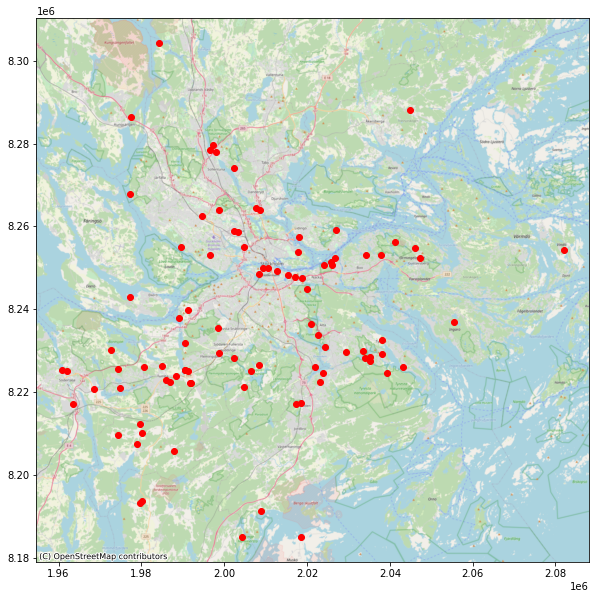

In [6]:
def filter_crags(crags, area_name, crag_type):
  local_crags = crags[crags.area_name == area_name]
  if crag_type == 'all':
    filtered_crags = local_crags
  elif crag_type == 'sport':
    filtered_crags = local_crags[local_crags.sport_count > 0]
  elif crag_type == 'trad':
    filtered_crags = local_crags[local_crags.trad_n_p_count > 0]
  elif crag_type == 'boulder':
    filtered_crags = local_crags[local_crags.boulder_count > 0]
  elif crag_type == 'dws':
    filtered_crags = local_crags[local_crags.dws_count > 0]
  
  return filtered_crags.reset_index(drop=True)

local_crags = filter_crags(crags_areas, CRAGS_AREA, CRAG_TYPE)

cx.add_basemap( \
  local_crags.to_crs(epsg=3857).plot(color='red', figsize=(10,10)), \
  crs='EPSG:3857', \
  source=cx.providers.OpenStreetMap.Mapnik)

## Travel time to the crag



In [7]:
def chunk(l, n):
  # split list into sublists of size <= n
  # preserving the order of elements
  for i in range(0, math.ceil(len(l) / n)):
    yield l[i * n : (i + 1) * n]

def extract_point_coordinates(gdf):
  return gdf.geometry.map(lambda p: {'lat': p.y, 'lng': p.x}).tolist()

def get_distance_by_transport(departure, destinations, departure_time, mode):
  def convert_distances(e):
    if e['status'] == 'OK':
      return {'distance': e['distance']['value'], 'duration': e['duration']['value']}
    else:
      return {'distance': None, 'duration': None}

  def parse_response(distances):
    distance_dicts = map(convert_distances, distances['rows'][0]['elements'])
    named_distances = zip(distances['destination_addresses'], distance_dicts)
    return pd.DataFrame(map(lambda z: {'google_address': z[0], **z[1]}, named_distances))

  gmaps = googlemaps.Client(key=open(GMAPS_API_KEY_PATH, 'r').read())
  # google set request limits
  return pd.concat([
    parse_response(gmaps.distance_matrix(departure, dest, departure_time=departure_time, mode=mode))
    for dest in chunk(destinations, 25)
  ]).reset_index(drop=True)

def add_travel_info(gdf, departure, departure_time, mode):
  # expects GDF with Point geometry in EPSG:4326
  coords = extract_point_coordinates(gdf)
  distances = get_distance_by_transport(departure, coords, departure_time, mode)
  return gdf.merge(distances, left_index=True, right_index=True)

local_crags_travel = cache_or_load_gdf( \
  './data/local_crags_travel.geojson', \
  lambda: add_travel_info(local_crags, TRAVEL_FROM, TRAVEL_DEPARTURE_TIME, TRAVEL_MODE))

local_crags_travel

,crag_id,crag_name,sport_count,trad_n_p_count,boulder_count,likes_count,premium_topo_active,dws_count,iso_a2,area_name,google_address,distance,duration,geometry
0,991,Kolartorp,1,0,523,52,False,0,SE,Stockholm,"Ängsvägen 49, 136 48 Handen, Sweden",26813.0,3800.0,POINT (18.12298 59.16955)
1,1104,Noret,90,28,0,34,True,0,SE,Stockholm,"Noretvägen 51, 135 69 Tyresö, Sweden",30624.0,4934.0,POINT (18.35367 59.21063)
2,1105,Örnberget,156,15,0,116,True,0,SE,Stockholm,"Tullinge strand 36, 146 40 Tullinge, Sweden",21710.0,2989.0,POINT (17.88211 59.20762)
3,1112,Nacka Kvarn,50,2,0,57,True,0,SE,Stockholm,"Ältavägen 97, 131 33 Nacka, Sweden",6975.0,1076.0,POINT (18.14678 59.29748)
4,1205,Flaten,126,6,0,47,True,0,SE,Stockholm,"Unnamed Road, 128 30 Skarpnäck, Sweden",11889.0,1883.0,POINT (18.15382 59.25872)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,22394,Vårbergssprickan,4,2,0,0,False,0,SE,Stockholm,"Vårholmsbackarna 114, 127 44 Skärholmen, Sweden",12857.0,1538.0,POINT (17.88690 59.27419)
89,23989,Astrazeneca,11,0,0,4,False,0,SE,Stockholm,"Österviksbacken 2, 151 56 Södertälje, Sweden",41414.0,4665.0,POINT (17.61356 59.20715)
90,24346,Buried routes on Hamra grustag,14,0,0,0,False,0,SE,Stockholm,"Rikstensvägen 31, 146 38 Tullinge, Sweden",20096.0,3420.0,POINT (17.89131 59.19283)
91,24764,Skrubba,2,0,0,1,False,0,SE,Stockholm,"Skrubbasandsvägen 4, 135 70 Stockholm, Sweden",15262.0,1722.0,POINT (18.18506 59.23243)


## Routes

Route infromation is only available per area so needs to be fetched as such

In [32]:
AREA_TO_ID = {
  "Alingsås": "382",
  "Boden": "335",
  "Bohuslän": "bohuslan",
  "Borås": "330",
  "Gävle": "328",
  "Göteborg": "327",
  "Halmstad": "326",
  "Helsingborg": "325",
  "Hässleholm": "373",
  "Höör": "hoor",
  "Jönköping": "324",
  "Kalmar": "372",
  "Karlshamn": "371",
  "Karlskoga": "370",
  "Karlstad": "323",
  "Kjugekull": "kjugekull-bouldering",
  "Kungälv": "364",
  "Lerum": "361",
  "Linköping": "322",
  "Märsta": "358",
  "Norrköping": "319",
  "Nyköping": "354",
  "Nynäshamn": "nynashamn-20045",
  "Nässjö": "356",
  "Piteå": "332",
  "Skellefteå": "331",
  "Sollentuna": "316",
  "Stockholm": "315",
  "Storuman": "8777",
  "Sundsvall": "348",
  "Södertälje": "317",
  "The pit": "the-pit-14478",
  "Tjörn": "tjorn",
  "Uddevalla": "344",
  "Umeå": "309",
  "Uppsala": "313",
  "Västervik": "vastervik",
  "Västerås": "312",
  "Växjö": "311",
  "Örebro": "318",
  "Örnsköldsvik": "353",
  "Östersund": "351"
}

def get_routes(area_id):
  routes_soup = BeautifulSoup(urlopen('https://27crags.com/areas/{}/routelist'.format(area_id)))
  raw_json = routes_soup.find(attrs={'data-component-name': 'RouteList'}).string
  parsed_json = json.loads(raw_json)
  return pd.DataFrame(parsed_json['routes'])

area_id = AREA_TO_ID[CRAGS_AREA]
routes = cache_or_load_df('./data/routes_{}.csv'.format(area_id), lambda: get_routes(area_id))
routes

,Unnamed: 0,id,name,genre,grade_int,rating,ascents_done_count,param_id,video_count,discussion_count,...,traverse,sitstart,topslasthold,tradgear_required,dangerous,crack,pockets,tufas,crag_name,crag_param_id
0,0,19803,Snoken,Sport,500,0.7222,90,snoken,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Noret,noret
1,1,23632,Ett småkryps liv,Sport,800,0.6452,31,ett-smakryps-liv,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Noret,noret
2,2,40913,Fusk,Sport,500,0.3571,29,fusk,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Noret,noret
3,3,41093,Kaksi,Sport,800,0.5714,14,kaksi,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Noret,noret
4,4,41600,Tuula,Sport,300,0.0000,5,tuula,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Noret,noret
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3033,3033,409660,Skorsten,Boulder,380,0.0000,0,skorsten,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Stora Björn,stora-bjorn
3034,3034,409661,Överhänget,Boulder,500,0.0000,0,overhanget-409661,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Stora Björn,stora-bjorn
3035,3035,409662,Första sprickan,Boulder,300,0.0000,0,forsta-sprickan,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Stora Björn,stora-bjorn
3036,3036,409663,Andra sprickan,Boulder,380,0.0000,0,andra-sprickan,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Stora Björn,stora-bjorn


# Crag Recommendation

Based on the travel time and routes in the given area recommendations might be constructed

In [57]:
GENRE_MAP = {
  'all': 'all',
  'sport': 'Sport',
  'trad': 'Traditional',
  'boulder': 'Boulder',
  'dws': 'DWS'
}

GRADES_MAP = {
  "?": 0,
  "3": 100,
  "3+": 150,
  "4": 200,
  "4+": 250,
  "5": 300,
  "5+": 370,
  "6a": 400,
  "6a+": 450,
  "6b": 500,
  "6b+": 550,
  "6c": 600,
  "6c+": 650,
  "7a": 700,
  "7a+": 750,
  "7b": 800,
  "7b+": 850,
  "7c": 900,
  "7c+": 950,
  "8a": 1000,
  "8a+": 1050,
  "8b": 1100,
  "8b+": 1150,
  "8c": 1200,
  "8c+": 1250,
  "9a": 1300,
  "9a+": 1350,
  "9b": 1400,
  "9b+": 1450,
  "9c": 1500
}

def filter_routes(crag_type, min_grade, max_grade, wall_type):
  by_crag = (routes.genre == GENRE_MAP[CRAG_TYPE])
  by_grade = (routes.grade_int >= GRADES_MAP[MIN_GRADE]) & (routes.grade_int <= GRADES_MAP[MAX_GRADE])
  if wall_type == 'any':
    by_wall_type = True
  else:
    by_wall_type = (routes[wall_type] > 0)

  return routes[by_crag & by_grade & by_wall_type]

routes_summary = filter_routes(CRAG_TYPE, MIN_GRADE, MAX_GRADE, WALL_TYPE) \
  .groupby(['crag_name']) \
  .agg(
    total_routes=pd.NamedAgg(column='id', aggfunc='count'),
    mean_rating=pd.NamedAgg(column='rating', aggfunc='mean'),
    crag_param_id=pd.NamedAgg(column='crag_param_id', aggfunc='min')) \
  .sort_values('total_routes', ascending=False)

routes_summary

,total_routes,mean_rating,crag_param_id
crag_name,,,
Münchenbryggeriet,32,0.124516,munchenbryggeriet
Örnberget,30,0.428493,ornberget
Ryssgraven,25,0.276592,ryssgraven
Gåseborg,24,0.139696,gaseborg
Fjärdhundra,21,0.320676,fjardhundra
Flaten,21,0.396519,flaten
Noret,19,0.209721,noret
Kanalklippan,18,0.287533,kanalklippan
Östnoraberget,17,0.197965,ostnora


In [59]:
recs = local_crags_travel \
  .join(routes_summary, on='crag_name', how='inner')\
  [['crag_name', 'crag_param_id', 'total_routes', 'sport_count', 'mean_rating', 'google_address', 'distance', 'duration']] \
  .rename({'total_routes': 'graded_count'})

recs['crag_param_id'] = recs['crag_param_id'].apply(lambda x: 'https://27crags.com/crags/{}'.format(x))
recs.rename({'crag_param_id': 'crag_url'}, inplace=True)
recs['distance'] = recs['distance'].apply(lambda d: '{} km'.format(d / 1000))
recs['duration'] = recs['duration'].apply(lambda d: '{} h'.format(round(d / 3600, 2)))
recs['mean_rating'] = recs['mean_rating'].apply(lambda r: round(r, 2))

recs.sort_values('duration', inplace=True)
recs.to_csv('./data/recs.csv')
recs

,crag_name,crag_param_id,total_routes,sport_count,mean_rating,google_address,distance,duration
16,Münchenbryggeriet,https://27crags.com/crags/munchenbryggeriet,32,45,0.12,"Söder Mälarstrand 45, 118 25 Stockholm, Sweden",1.775 km,0.17 h
25,Henriksdal,https://27crags.com/crags/henriksdalsklippan,7,26,0.49,"Henriksdalsringen 103, 131 32 Nacka, Sweden",4.543 km,0.21 h
3,Nacka Kvarn,https://27crags.com/crags/nacka-kvarn,8,50,0.21,"Ältavägen 97, 131 33 Nacka, Sweden",6.975 km,0.3 h
18,Anneberg,https://27crags.com/crags/anneberg,6,20,0.36,"Utskogsvägen 39, 131 46 Nacka, Sweden",11.924 km,0.44 h
4,Flaten,https://27crags.com/crags/flaten,21,126,0.40,"Unnamed Road, 128 30 Skarpnäck, Sweden",11.889 km,0.52 h
62,Fredriksvik,https://27crags.com/crags/nyckelviksberget,5,17,0.00,"FREDRIKSVIKSSTIGEN 2, 131 47 Nacka, Sweden",12.929 km,0.52 h
78,Nyckelviksberget,https://27crags.com/crags/nyckelviksberget-19100,15,61,0.00,"Apportvägen, 131 47 Nacka, Sweden",12.855 km,0.55 h
22,Kanalklippan,https://27crags.com/crags/kanalklippan,18,23,0.29,"Hästholmsvägen 17, 116 44 Stockholm, Sweden",2.793 km,0.57 h
29,Baggeby,https://27crags.com/crags/baggeby,6,13,0.39,"Barkassvägen 5, 181 35 Lidingö, Sweden",9.187 km,0.57 h
17,Ekstubbeberget,https://27crags.com/crags/ekstubbeberget,10,31,0.40,"Skrubba Koloniväg, 135 59 Stockholm, Sweden",14.155 km,0.59 h
